In [1]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.pm import PolynomialMutation
import numpy as np
from itertools import product,combinations
import matplotlib.pyplot as plt

from functools import partial
import sobol_seq
import re

**Problem 1 Pak Kun**

In [2]:
epsilon = -1+1e-3
delta = 1e-2
dim = 2
p_mutation = 0.1

gamma = -0.2
m_cluster = 100
k_cluster = 10
m = 100
k_max = 1000
seed = np.random.randint(0,100)
print(f"seed={seed}")

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

boundaries = np.array([(-10,10) for _ in range (dim)])

seed=63


# Root Objective Function

In [3]:
def root_objective_function(x:np.ndarray):
    F_array = objective_function(x)
    denom = 0
    for f in F_array:
        denom +=np.abs(f)
    F = 1/(1+denom)
    return -F

# Optimization Algorithm

In [4]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem

In [5]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10,
                    sobol = True):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    if sobol == True:
        # Generate Sobol sequence points
        sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)
        # Scale the Sobol points to fit within the specified boundaries
        scaled_points = []
        for i in range(dim):
            a, b = boundaries[i]
            scaled_dim = a + sobol_points[:, i] * (b - a)
            scaled_points.append(scaled_dim)
        # Transpose the scaled points to get points per dimension
        scaled_points = np.array(list(map(list, zip(*scaled_points))))
    
    else:
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points

# def initialize_population(pop_size, dimensions, bounds):
#     population = np.random.rand(pop_size, dimensions)
#     lower_bounds, upper_bounds = np.asarray(bounds).T
#     diff = np.fabs(lower_bounds - upper_bounds)
#     return lower_bounds + population * diff

In [6]:
# # GA parameter
# mutation = PolynomialMutation(prob=p_mutation)
# algorithm_GA_cluster = GA(eliminate_duplicates=True,
#                           mutation=mutation)

# class myProblem(ElementwiseProblem):
#     def __init__(self):
#         super().__init__(n_var=2,n_obj=1,xl=boundaries[:,0],xu=boundaries[:,1])
#     def _evaluate(self, x, out, *args, **kwargs):
#         out['F'] = root_objective_function(x)

# problem = myProblem()

# x_init = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1],sobol=True)


# result = minimize(problem=problem,
#                algorithm=algorithm_GA_cluster,
#                termination=('n_gen', 1),  # Next Generation
#                X_init = x_init,
#                seed = seed,
#                verbose=False)

# offspring = result.pop.get("X")
# offspring

In [7]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-1.25  1.25]] [10.]


In [8]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    # min_dist_cluster = 10**100
    # for ci,cc in cluster_center.items():
    #     dist = np.linalg.norm(cc-y)
    #     if dist<=min_dist_cluster:
    #         xc = cc
    #         cluster_id = ci
    #         min_dist_cluster = dist
    global cluster_center
    global cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y
    
    # update radii if the existing corresponding cluster radii is larger than tha candidate
    if cluster_radius[min_dist_id] > np.linalg.norm(y-xt):
        cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    
    # return cluster_center,cluster_radius


In [9]:
mutation = PolynomialMutation(prob=p_mutation)
algorithm_GA_cluster = GA(eliminate_duplicates=True,
                          mutation=mutation)

class myProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=2,n_obj=1,xl=boundaries[:,0],xu=boundaries[:,1])
    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = root_objective_function(x)

problem = myProblem()

while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])
    fitness_k = np.asarray([root_objective_function(ind) for ind in iter_points[k]])
    i_g = np.argmin(fitness)
    x_i_g = iter_points[k][i_g]
    iter_points[k+1] = np.copy(iter_points[k])
    res = minimize(problem=problem,
                   algorithm=algorithm_GA_cluster,
                   termination=('n_gen', 2),  # Next Generation
                   X_init = iter_points[k],
                   seed = None,
                   verbose=False)
    iter_points[k+1] = res.pop.get("X")

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")
print(f"len(cluster_radius)={len(cluster_radius)}\ncluster_radius={cluster_radius}")

len(cluster_center)=33
cluster_center=[[-0.94186315  1.03266789]
 [ 0.60962903  0.78817885]
 [-0.52815376  0.74013204]
 [-5.06370448  0.10265286]
 [-0.08464778  7.52051495]
 [-0.58396811  0.98100608]
 [-5.31599234  0.09600715]
 [-5.14780043  0.10043762]
 [-5.90247621 -0.10008198]
 [-0.11958901  5.11853321]
 [-0.0858535   3.50226193]
 [ 0.01645299  4.50733711]
 [ 0.86181133  0.90768345]
 [-0.50927485  1.47347194]
 [-8.85031555 -0.02767366]
 [-6.82788694 -0.13971475]
 [-0.01383894  2.11514958]
 [-0.9462263   1.12783578]
 [-0.08703892  0.84492126]
 [-0.02572309  9.64062702]
 [ 0.09835089  6.19016517]
 [ 0.09835089  6.03279341]
 [-0.07963421  2.30045876]
 [-1.55317242 -0.09141539]
 [-2.50055999 -0.05037245]
 [-9.91784836  0.06885782]
 [ 0.05021102  3.11172252]
 [-0.08464778  7.52509665]
 [-0.09588892  5.77669914]
 [-1.91294097  0.51176804]
 [-2.30468699  0.13700771]
 [-7.83842579 -0.03508308]
 [-0.30886538  0.98100608]]
len(cluster_radius)=33
cluster_radius=[4.76339268e-02 6.23158488e-02 7

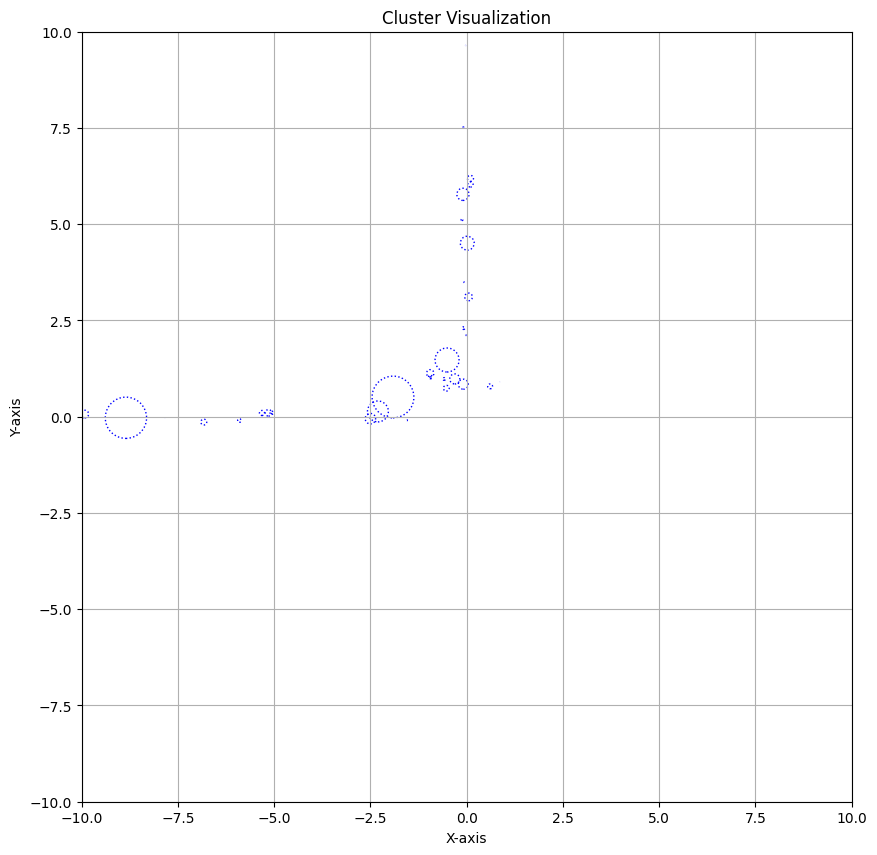

In [10]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
    
ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [11]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


cluster_center[0] x answ[1]
cluster_center[17] x answ[1]


# SDGA Evaluation

In [12]:
def GenAl(n_var,
          n_obj,
          xl,
          xu,
          objective_function,
          algorithmGA,
          termination,
          seed=1,
          verbose=False):
    
    class myProblem(ElementwiseProblem):
        def __init__(self):
            super().__init__(n_var=n_var,n_obj=n_obj,xl=xl,xu=xu)
        def _evaluate(self, x, out, *args, **kwargs):
            out['F'] = objective_function(x)

    problem = myProblem()
    result = minimize(
        problem=problem,
        algorithm=algorithmGA,
        termination=termination,
        seed=seed,
        verbose=verbose)
    
    return [result.X,result.F]

In [13]:
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation

In [14]:
# GA parameter
sampling = FloatRandomSampling()
# crossover = SimulatedBinaryCrossover(prob=0.9, eta=15)
mutation = PolynomialMutation(prob=p_mutation)

algorithmGA = GA(
    pop_size=m_cluster,
    eliminate_duplicates=True,
    sampling=sampling,
    mutation=mutation)


# termination variable
terminationp1 = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=k_max,
    n_max_evals=100000
)

archive = []
for i in range (len(cluster_center)):
    subbound = np.array([cluster_center[i]-cluster_radius[i],cluster_center[i]+cluster_radius[i]])

    root, root_score = GenAl(
        n_var=2,
        n_obj=1,
        xl=subbound[:,0],
        xu=subbound[:,0],
        objective_function=root_objective_function,
        algorithmGA=algorithmGA,
        termination=terminationp1,
        seed=None)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([-0.98949708, -0.89422922])]

====== Cluster 1 ======

Roots = [array([-0.98949708, -0.89422922]), array([0.54731319, 0.67194488])]

====== Cluster 2 ======

Roots = [array([-0.98949708, -0.89422922]), array([0.54731319, 0.67194488]), array([-0.60337773, -0.4529298 ])]

====== Cluster 3 ======

Roots = [array([-0.98949708, -0.89422922]), array([0.54731319, 0.67194488]), array([-0.60337773, -0.4529298 ]), array([-5.10576704, -5.02164191])]

====== Cluster 4 ======

Roots = [array([-0.98949708, -0.89422922]), array([0.54731319, 0.67194488]), array([-0.60337773, -0.4529298 ]), array([-5.10576704, -5.02164191]), array([-0.08693864, -0.08235693])]

====== Cluster 5 ======

Roots = [array([-0.98949708, -0.89422922]), array([0.54731319, 0.67194488]), array([-0.60337773, -0.4529298 ]), array([-5.10576704, -5.02164191]), array([-0.08693864, -0.08235693]), array([-0.6185891 , -0.54934712])]

====== Cluster 6 ======

Roots = [array([-0.98949708, -0.8942292

[array([-0.98949708, -0.89422922]),
 array([0.54731319, 0.67194488]),
 array([-0.60337773, -0.4529298 ]),
 array([-5.10576704, -5.02164191]),
 array([-0.08693864, -0.08235693]),
 array([-0.6185891 , -0.54934712]),
 array([-5.38157264, -5.25041203]),
 array([-5.23192555, -5.06367531]),
 array([-5.94823489, -5.85671753]),
 array([-0.14224231, -0.09693572]),
 array([-0.10098028, -0.07072673]),
 array([-0.16346998,  0.19637596]),
 array([0.86170505, 0.86191762]),
 array([-0.82082736, -0.19772233]),
 array([-9.38625972, -8.31437137]),
 array([-6.90405217, -6.75172172]),
 array([-0.0189695 , -0.00870839]),
 array([-1.04149415, -0.85095845]),
 array([-0.21716007,  0.04308223]),
 array([-0.0266697 , -0.02477649]),
 array([0.01966501, 0.17703677]),
 array([0.02981408, 0.16688769]),
 array([-0.11346277, -0.04580566]),
 array([-1.56450662, -1.54183822]),
 array([-2.63609372, -2.36502627]),
 array([-10.0169832 ,  -9.81871353]),
 array([-0.04904883,  0.14947087]),
 array([-0.08922949, -0.08006608])

In [15]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([], dtype=float64)

In [16]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([], dtype=float64)